# Imports

In [1]:
import geopandas as gpd #local shape processing
import rioxarray as rxr #local raster processing
import leafmap #local interactive visualisation
import matplotlib.pyplot as plt #python plotting package

# Shape processing

## Read shape

In [2]:
catchment_gdf = gpd.read_file("data/catchment.geojson")

## Plot shape

<AxesSubplot: >

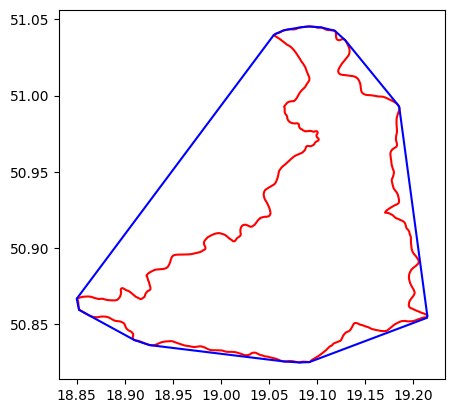

In [3]:
fig, ax = plt.subplots()
catchment_gdf.boundary.plot(ax=ax, color="red")
catchment_gdf.convex_hull.boundary.plot(ax=ax, color="blue")

# Raster processing
## Load HDF dataset

In [4]:
modis_hdf = rxr.open_rasterio("data/MOD11A1.A2022272.h19v03.061.2022273091950.hdf", cache=False)
modis_hdf

<xarray.Dataset>
Dimensions:          (band: 1, x: 1200, y: 1200)
Coordinates:
  * band             (band) int64 1
  * x                (x) float64 1.112e+06 1.113e+06 ... 2.223e+06 2.223e+06
  * y                (y) float64 6.671e+06 6.67e+06 ... 5.561e+06 5.56e+06
    spatial_ref      int64 0
Data variables:
    LST_Day_1km      (band, y, x) uint16 ...
    Emis_32          (band, y, x) uint8 ...
    Clear_day_cov    (band, y, x) uint16 ...
    Clear_night_cov  (band, y, x) uint16 ...
    QC_Day           (band, y, x) uint8 ...
    Day_view_time    (band, y, x) uint8 ...
    Day_view_angl    (band, y, x) uint8 ...
    LST_Night_1km    (band, y, x) uint16 ...
    QC_Night         (band, y, x) uint8 ...
    Night_view_time  (band, y, x) uint8 ...
    Night_view_angl  (band, y, x) uint8 ...
    Emis_31          (band, y, x) uint8 ...
Attributes: (12/117)
    ALGORITHMPACKAGEACCEPTANCEDATE:     102004
    ALGORITHMPACKAGEMATURITYCODE:       Normal
    ALGORITHMPACKAGENAME:               MOD_PR11A
    ALGORITHMPACKAGEVERSION:            6
    ASSOCIATEDINSTRUMENTSHORTNAME.1:    MODIS
    ASSOCIATEDPLATFORMSHORTNAME.1:      Terra
    ...                                 ...
    SOUTHBOUNDINGCOORDINATE:            50.0041666666667
    SPSOPARAMETERS:                     2484 and 3323
    TileID:                             51019003
    VERSIONID:                          61
    VERTICALTILENUMBER:                 3
    WESTBOUNDINGCOORDINATE:             15.5534662098949

## Get raster from HDF

In [5]:
#select LST product from hdf
lst = modis_hdf["LST_Day_1km"]

## Scaling pixel values

In [6]:
#apply scaling (value from MODIS documentation)
lst[0] = lst[0]*0.02


## Nodata

### Nodata issue

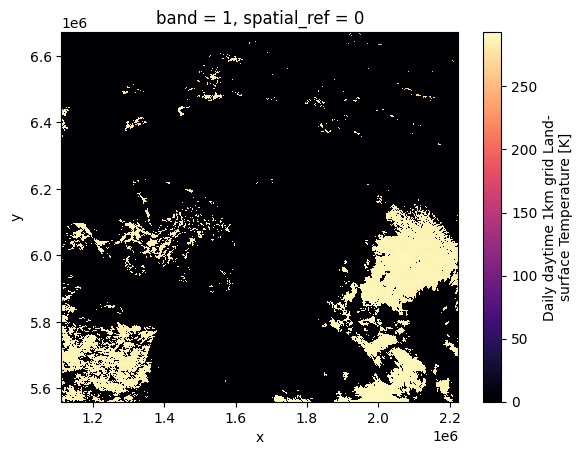

In [7]:
#plot LST
lst.plot(cmap="magma")

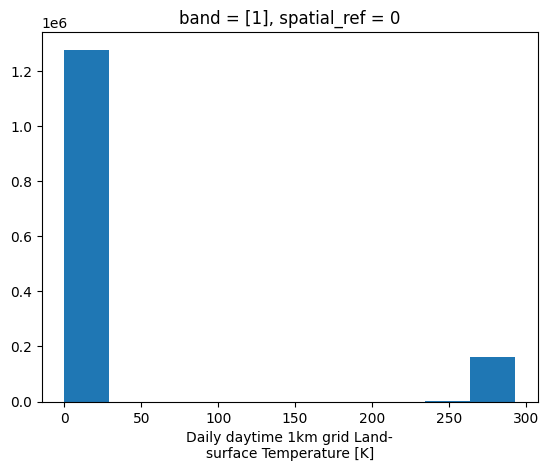

In [8]:
lst.plot.hist()
plt.show()

In [9]:
print(f"nodata: {lst.rio.nodata}")
print(f"encoded_nodata: {lst.rio.encoded_nodata}")

nodata: 0
encoded_nodata: None


### Masking nodata

In [10]:
#mask nodata
lst = lst.where(lst!=lst.rio.nodata)
#write nodata metadata
lst = lst.rio.write_nodata(-9999, encoded=True)

nodata: nan
encoded_nodata: -9999.0


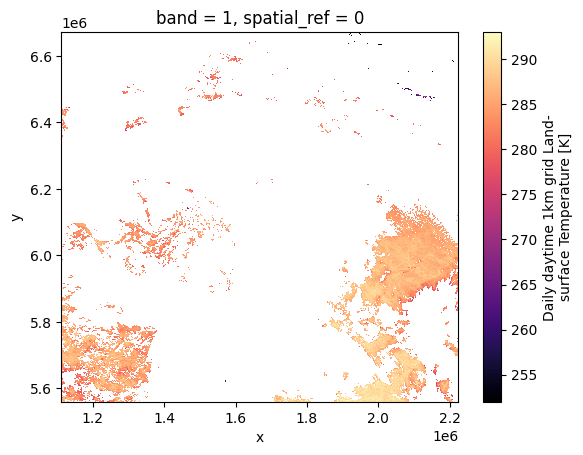

In [11]:
print(f"nodata: {lst.rio.nodata}")
print(f"encoded_nodata: {lst.rio.encoded_nodata}")
lst.plot(cmap="magma")

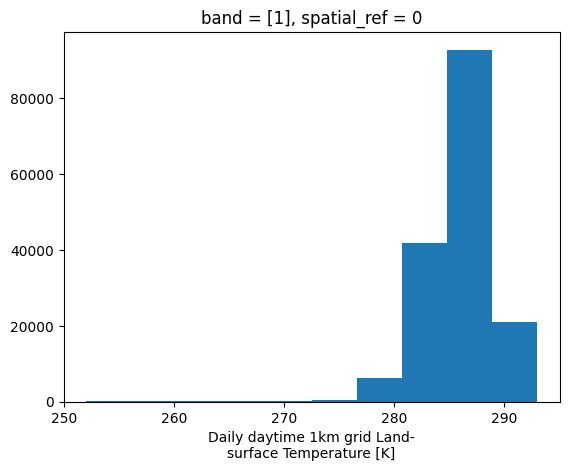

In [12]:
lst.plot.hist()
plt.show()

## Save raster

In [13]:
#save LST to tif file
lst.rio.to_raster("data/lst.tif")

## Crop raster using shape

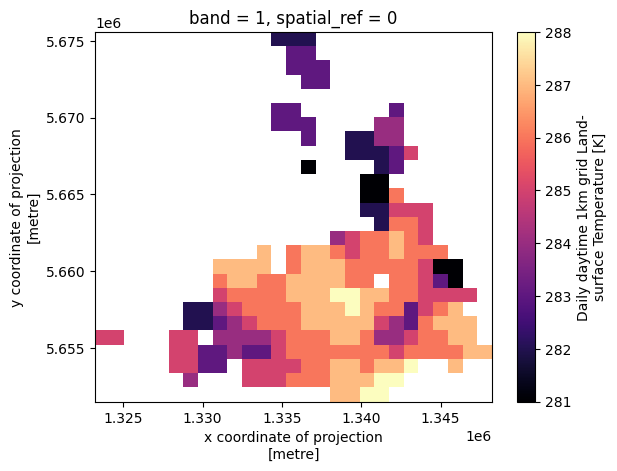

In [14]:
lst = lst.rio.clip(catchment_gdf.geometry.values,catchment_gdf.crs)
lst.rio.to_raster("data/lst_cropped.tif")
lst.plot(cmap="magma")

## Plot raster and shape on one canvas

### Problem with plotting different CRS

<AxesSubplot: title={'center': 'band = 1, spatial_ref = 0'}, xlabel='x coordinate of projection\n[metre]', ylabel='y coordinate of projection\n[metre]'>

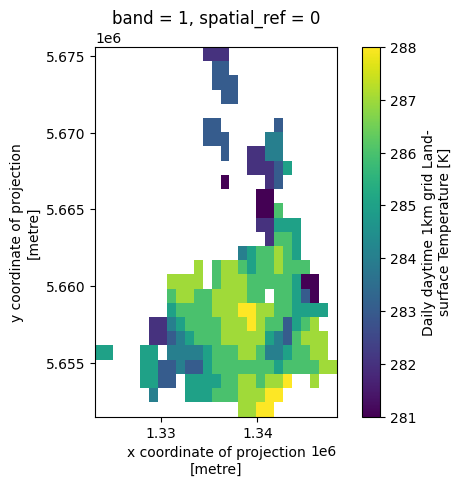

In [15]:
#plot results
fig, ax = plt.subplots()
lst.plot(ax=ax)
catchment_gdf.boundary.plot(ax=ax, color="red")

### Shape reprojection

In [17]:
catchment_gdf_sin = catchment_gdf.to_crs(lst.rio.crs)

<AxesSubplot: title={'center': 'band = 1, spatial_ref = 0'}, xlabel='x coordinate of projection\n[metre]', ylabel='y coordinate of projection\n[metre]'>

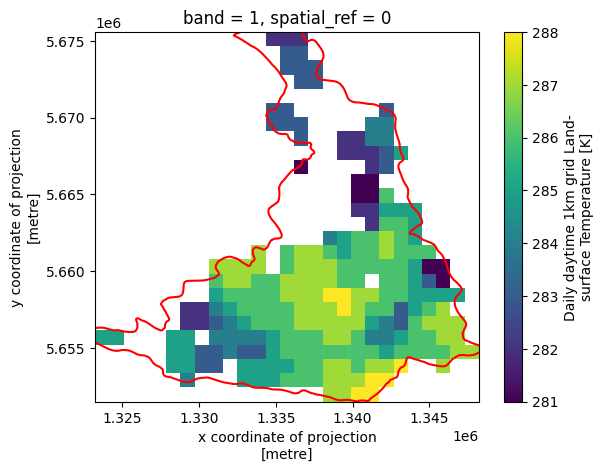

In [19]:
#plot results
fig, ax = plt.subplots()
lst.plot(ax=ax)
catchment_gdf_sin.boundary.plot(ax=ax, color="red")

## Raster reprojection

CRS before reprojection: PROJCS["unnamed",GEOGCS["Unknown datum based upon the custom spheroid",DATUM["Not_specified_based_on_custom_spheroid",SPHEROID["Custom spheroid",6371007.181,0]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Sinusoidal"],PARAMETER["longitude_of_center",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["Meter",1],AXIS["Easting",EAST],AXIS["Northing",NORTH]]



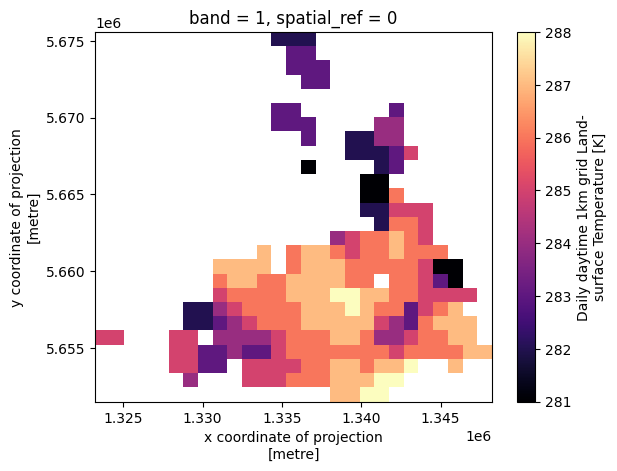

In [21]:
print(f"CRS before reprojection: {lst.rio.crs}\n")
lst.plot(cmap="magma")

CRS after reprojection: EPSG:4326


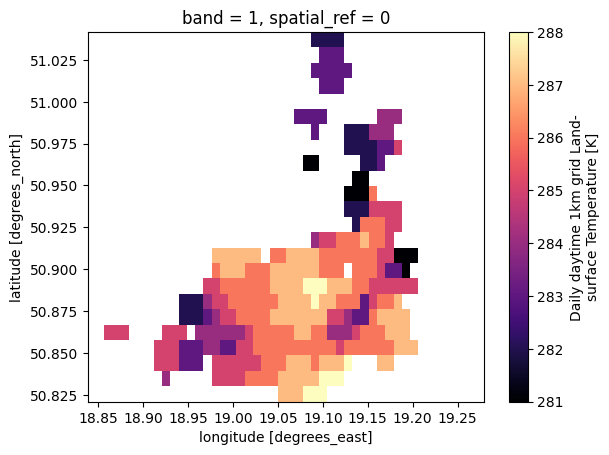

In [26]:
lst = lst.rio.reproject("EPSG:4326")
print(f"CRS after reprojection: {lst.rio.crs}")
lst.plot(cmap="magma")

# Interactive map visualization

In [24]:
Map = leafmap.Map()
#visualise raster by path
Map.add_raster("data/lst_cropped.tif", layer_name="LST")
#visualise shape by path
Map.add_geojson("data/catchment.geojson", layer_name="Catchment", fill_colors=['red'])
#visualise geodataframe shape object
Map.add_gdf(catchment_gdf.convex_hull, layer_name="Catchment - convex hull", fill_colors=['blue'])
Map

Map(center=[20, 0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text…